# Deep Learning with PyTorch


Author: [Anand Saha](http://teleported.in/)

### 2. Building a simple neural network

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.autograd import Variable

# Custom DataSet
from data import iris

### The Dataset and the challenge

![iris](data/iris.jpg)

The **Iris** flower, image source: [Wikimedia](https://en.wikipedia.org/wiki/Iris_(plant))


| sepal_length_cm | sepal_width_cm | petal_length_cm | petal_width_cm | class           |
|-----------------|----------------|-----------------|----------------|-----------------|
| 5.1             | 3.5            | 1.4             | 0.2            | Iris-setosa     |
| 7.0             | 3.2            | 4.7             | 1.4            | Iris-versicolor |
| 6.3             | 3.3            | 6.0             | 2.5            | Iris-virginica  |


* Total instances: 150 (we have separated 20% into validation set, rest into training set)
* Download: [Data Source](https://archive.ics.uci.edu/ml/datasets/iris)

### Let's do a head on the raw file

In [2]:
!head data/iris.data.txt

sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,Iris-setosa
5.0,3.6,1.4,0.2,Iris-setosa
5.4,3.9,1.7,0.4,Iris-setosa
4.6,3.4,1.4,0.3,Iris-setosa
5.0,3.4,1.5,0.2,Iris-setosa
4.4,2.9,1.4,0.2,Iris-setosa


### Create the Fully Connected Feed Forward Neural Network

**Create the module**

In [3]:
class IrisNet(nn.Module):
    
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

**Print the module**

In [4]:
model = IrisNet(4, 100, 50, 3)
print(model)

IrisNet(
  (fc1): Linear(in_features=4, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=50, out_features=3, bias=True)
)


### Create the DataLoader

In [5]:
batch_size = 60
iris_data_file = 'data/iris.data.txt'

In [6]:
# Get the datasets
train_ds, test_ds = iris.get_datasets(iris_data_file)

# How many instances have we got?
print('# instances in training set: ', len(train_ds))
print('# instances in testing/validation set: ', len(test_ds))

# Create the dataloaders - for training and validation/testing
# We will be using the term validation and testing data interchangably
train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=True)

# instances in training set:  120
# instances in testing/validation set:  30


### Instantiate the network, the loss function and the optimizer

In [7]:
# Our model
net = IrisNet(4, 100, 50, 3).cuda()

# Out loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, nesterov=True, momentum=0.9, dampening=0)  

### Train it!

In [8]:
num_epochs = 500

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
    
    train_correct = 0
    train_total = 0
    
    for i, (items, classes) in enumerate(train_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items.cuda())
        classes = Variable(classes.cuda())
        
        net.train()           # Put the network into training mode
        
        optimizer.zero_grad() # Clear off the gradients from any past operation
        outputs = net(items)  # Do the forward pass
        loss = criterion(outputs, classes) # Calculate the loss
        #print("loss is", loss)
        loss.backward()       # Calculate the gradients with help of back propagation
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data
        train_total += classes.size(0)    
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == classes.data).sum()

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, i+1, len(train_ds)//batch_size, loss.item()))

    net.eval()                 # Put the network into evaluation mode
    
    # Book keeping
    # Record the loss
    train_loss.append(loss.item())

    # What was our train accuracy?
    train_accuracy.append((100 * train_correct / train_total))
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    test_items = torch.FloatTensor(test_ds.data.values[:, 0:4])
    test_classes = torch.LongTensor(test_ds.data.values[:, 4])

    outputs = net(Variable(test_items.cuda()))
    loss = criterion(outputs, Variable(test_classes.cuda()))
    test_loss.append(loss.item())
    _, predicted = torch.max(outputs.data, 1)
    total = test_classes.size(0)
    correct = (predicted == test_classes.cuda()).sum()
    test_accuracy.append((100 * correct / total))

Epoch 1/500, Iteration 1/2, Loss: 1.1454
Epoch 1/500, Iteration 2/2, Loss: 1.1317
Epoch 2/500, Iteration 1/2, Loss: 1.1504
Epoch 2/500, Iteration 2/2, Loss: 1.0897
Epoch 3/500, Iteration 1/2, Loss: 1.1238
Epoch 3/500, Iteration 2/2, Loss: 1.0690
Epoch 4/500, Iteration 1/2, Loss: 1.0762
Epoch 4/500, Iteration 2/2, Loss: 1.0734
Epoch 5/500, Iteration 1/2, Loss: 1.0719
Epoch 5/500, Iteration 2/2, Loss: 1.0449
Epoch 6/500, Iteration 1/2, Loss: 1.0369
Epoch 6/500, Iteration 2/2, Loss: 1.0511
Epoch 7/500, Iteration 1/2, Loss: 1.0230
Epoch 7/500, Iteration 2/2, Loss: 1.0393
Epoch 8/500, Iteration 1/2, Loss: 1.0319
Epoch 8/500, Iteration 2/2, Loss: 1.0138
Epoch 9/500, Iteration 1/2, Loss: 1.0179
Epoch 9/500, Iteration 2/2, Loss: 0.9982
Epoch 10/500, Iteration 1/2, Loss: 0.9800
Epoch 10/500, Iteration 2/2, Loss: 1.0072
Epoch 11/500, Iteration 1/2, Loss: 0.9906
Epoch 11/500, Iteration 2/2, Loss: 0.9716
Epoch 12/500, Iteration 1/2, Loss: 0.9506
Epoch 12/500, Iteration 2/2, Loss: 0.9910
Epoch 13/5

Epoch 110/500, Iteration 1/2, Loss: 0.3306
Epoch 110/500, Iteration 2/2, Loss: 0.3190
Epoch 111/500, Iteration 1/2, Loss: 0.3406
Epoch 111/500, Iteration 2/2, Loss: 0.3047
Epoch 112/500, Iteration 1/2, Loss: 0.3635
Epoch 112/500, Iteration 2/2, Loss: 0.2769
Epoch 113/500, Iteration 1/2, Loss: 0.3252
Epoch 113/500, Iteration 2/2, Loss: 0.3105
Epoch 114/500, Iteration 1/2, Loss: 0.2841
Epoch 114/500, Iteration 2/2, Loss: 0.3476
Epoch 115/500, Iteration 1/2, Loss: 0.3164
Epoch 115/500, Iteration 2/2, Loss: 0.3103
Epoch 116/500, Iteration 1/2, Loss: 0.3171
Epoch 116/500, Iteration 2/2, Loss: 0.3050
Epoch 117/500, Iteration 1/2, Loss: 0.3157
Epoch 117/500, Iteration 2/2, Loss: 0.3019
Epoch 118/500, Iteration 1/2, Loss: 0.3076
Epoch 118/500, Iteration 2/2, Loss: 0.3057
Epoch 119/500, Iteration 1/2, Loss: 0.2890
Epoch 119/500, Iteration 2/2, Loss: 0.3199
Epoch 120/500, Iteration 1/2, Loss: 0.3085
Epoch 120/500, Iteration 2/2, Loss: 0.2960
Epoch 121/500, Iteration 1/2, Loss: 0.3246
Epoch 121/5

Epoch 214/500, Iteration 1/2, Loss: 0.1792
Epoch 214/500, Iteration 2/2, Loss: 0.1552
Epoch 215/500, Iteration 1/2, Loss: 0.1463
Epoch 215/500, Iteration 2/2, Loss: 0.1873
Epoch 216/500, Iteration 1/2, Loss: 0.1862
Epoch 216/500, Iteration 2/2, Loss: 0.1450
Epoch 217/500, Iteration 1/2, Loss: 0.1644
Epoch 217/500, Iteration 2/2, Loss: 0.1655
Epoch 218/500, Iteration 1/2, Loss: 0.1552
Epoch 218/500, Iteration 2/2, Loss: 0.1729
Epoch 219/500, Iteration 1/2, Loss: 0.1595
Epoch 219/500, Iteration 2/2, Loss: 0.1669
Epoch 220/500, Iteration 1/2, Loss: 0.1683
Epoch 220/500, Iteration 2/2, Loss: 0.1566
Epoch 221/500, Iteration 1/2, Loss: 0.1673
Epoch 221/500, Iteration 2/2, Loss: 0.1558
Epoch 222/500, Iteration 1/2, Loss: 0.1535
Epoch 222/500, Iteration 2/2, Loss: 0.1685
Epoch 223/500, Iteration 1/2, Loss: 0.1722
Epoch 223/500, Iteration 2/2, Loss: 0.1482
Epoch 224/500, Iteration 1/2, Loss: 0.1627
Epoch 224/500, Iteration 2/2, Loss: 0.1561
Epoch 225/500, Iteration 1/2, Loss: 0.1994
Epoch 225/5

Epoch 310/500, Iteration 2/2, Loss: 0.0686
Epoch 311/500, Iteration 1/2, Loss: 0.1315
Epoch 311/500, Iteration 2/2, Loss: 0.1008
Epoch 312/500, Iteration 1/2, Loss: 0.0894
Epoch 312/500, Iteration 2/2, Loss: 0.1420
Epoch 313/500, Iteration 1/2, Loss: 0.1393
Epoch 313/500, Iteration 2/2, Loss: 0.0920
Epoch 314/500, Iteration 1/2, Loss: 0.0950
Epoch 314/500, Iteration 2/2, Loss: 0.1379
Epoch 315/500, Iteration 1/2, Loss: 0.1306
Epoch 315/500, Iteration 2/2, Loss: 0.0989
Epoch 316/500, Iteration 1/2, Loss: 0.1254
Epoch 316/500, Iteration 2/2, Loss: 0.1064
Epoch 317/500, Iteration 1/2, Loss: 0.1232
Epoch 317/500, Iteration 2/2, Loss: 0.1067
Epoch 318/500, Iteration 1/2, Loss: 0.1370
Epoch 318/500, Iteration 2/2, Loss: 0.0906
Epoch 319/500, Iteration 1/2, Loss: 0.1149
Epoch 319/500, Iteration 2/2, Loss: 0.1123
Epoch 320/500, Iteration 1/2, Loss: 0.1179
Epoch 320/500, Iteration 2/2, Loss: 0.1091
Epoch 321/500, Iteration 1/2, Loss: 0.1228
Epoch 321/500, Iteration 2/2, Loss: 0.1035
Epoch 322/5

Epoch 414/500, Iteration 1/2, Loss: 0.0997
Epoch 414/500, Iteration 2/2, Loss: 0.0869
Epoch 415/500, Iteration 1/2, Loss: 0.0716
Epoch 415/500, Iteration 2/2, Loss: 0.1160
Epoch 416/500, Iteration 1/2, Loss: 0.0762
Epoch 416/500, Iteration 2/2, Loss: 0.1099
Epoch 417/500, Iteration 1/2, Loss: 0.1258
Epoch 417/500, Iteration 2/2, Loss: 0.0600
Epoch 418/500, Iteration 1/2, Loss: 0.0960
Epoch 418/500, Iteration 2/2, Loss: 0.0913
Epoch 419/500, Iteration 1/2, Loss: 0.0897
Epoch 419/500, Iteration 2/2, Loss: 0.0955
Epoch 420/500, Iteration 1/2, Loss: 0.0462
Epoch 420/500, Iteration 2/2, Loss: 0.1387
Epoch 421/500, Iteration 1/2, Loss: 0.0980
Epoch 421/500, Iteration 2/2, Loss: 0.0875
Epoch 422/500, Iteration 1/2, Loss: 0.0765
Epoch 422/500, Iteration 2/2, Loss: 0.1124
Epoch 423/500, Iteration 1/2, Loss: 0.0980
Epoch 423/500, Iteration 2/2, Loss: 0.0880
Epoch 424/500, Iteration 1/2, Loss: 0.0607
Epoch 424/500, Iteration 2/2, Loss: 0.1235
Epoch 425/500, Iteration 1/2, Loss: 0.0799
Epoch 425/5

Plot loss vs iterations

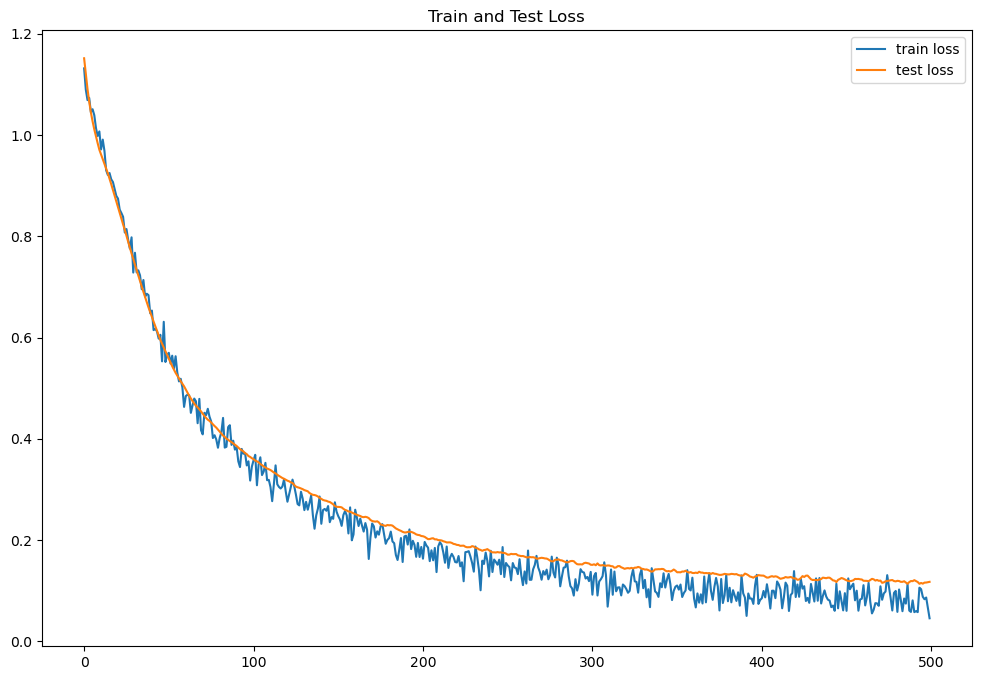

In [9]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.title("Train and Test Loss")
plt.legend()
plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

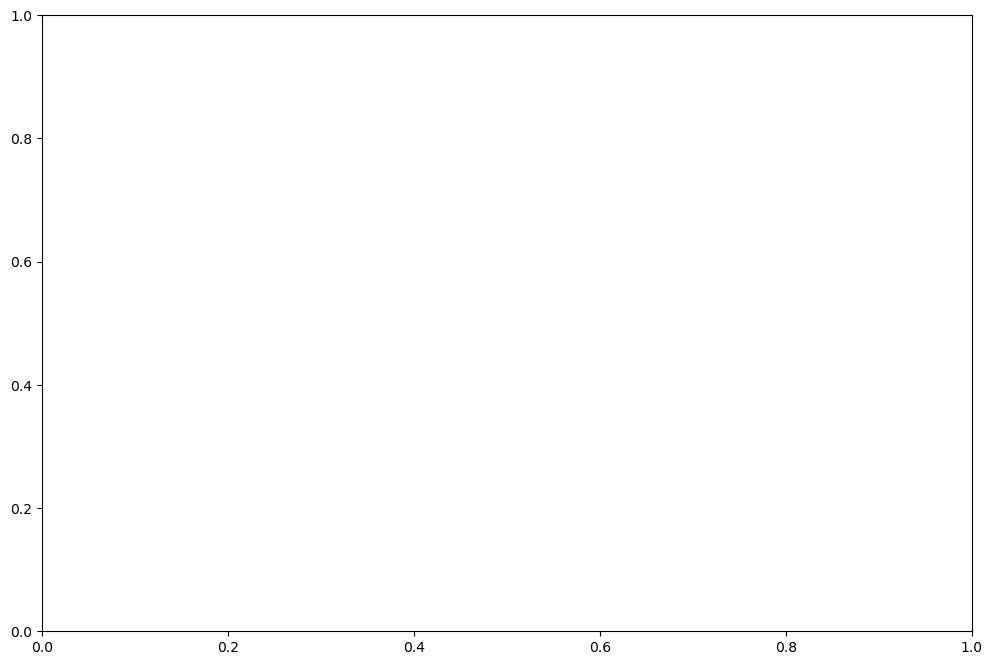

In [10]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_accuracy, label='train accuracy')
plt.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
plt.legend()
plt.show()

### Saving the model to disk, and loading it back

In [ ]:
torch.save(net.state_dict(), "./2.model.pth")

In [ ]:
net2 = IrisNet(4, 100, 50, 3)
net2.load_state_dict(torch.load("./2.model.pth"))

In [ ]:
output = net2(Variable(torch.FloatTensor([[5.1, 3.5, 1.4, 0.2]])))

In [ ]:
_, predicted_class = torch.max(output.data, 1)
print('Predicted class: ', predicted_class.numpy()[0])
print('Expected class: ', 0 )